알약 카운팅 모델

주제 선정 이유
약사분들이 알약 포장을 할때 알약 개수는 어떻게 세는건지라는 궁금증에서 시작되어서 겹쳐 있는 알약은 어떻게 카운팅 되는지 궁금해서 시작하게 됨

사용할 핵심 디지털 영상처리 알고리즘

erosin(침식)으로 2개이상의 객체가 붙어있을때 다른 객체로 인식 시키기 위해 사용

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os


drive.mount('/content/gdrive')

Mounted at /content/gdrive


라이브러리 임포트

(4000, 6000, 3)


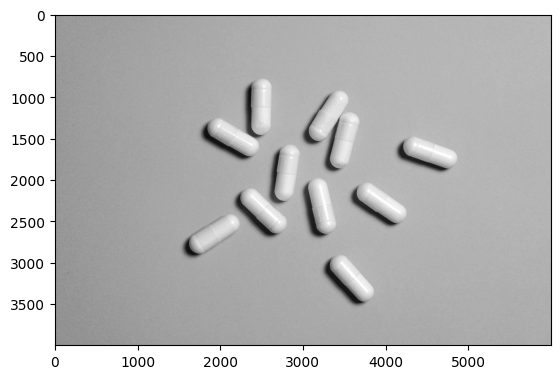

In [2]:
img = cv2.imread('/content/gdrive/My Drive/IP/Images/test.jpg')
print(img.shape)
gimg=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gimg, cmap='gray')

이미지 로드

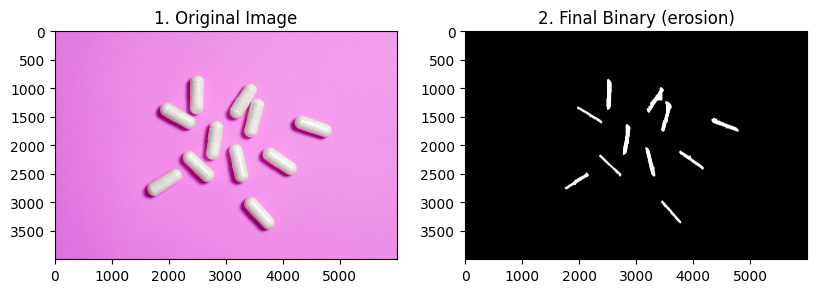

In [7]:
# 1단계: 전처리 및 이진화

# 1. 흑백 변환
# 이진화를 위해 미리 흑백변환을 시도
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. 노이즈 제거 (가우시안 필터)
# 노이즈 제거를 위한 7x7 크기의 마스크로 가우시안 필터를 적용해 노이즈를 제거
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# 3. 이진화 (Thresholding)
# 배경 노이즈 제거를 위한 수동 임계값 설정

THRESHOLD_VALUE = 200
# 객체와 배경을 나눌 임계값을 200으로 설정

_, thresh = cv2.threshold(blurred, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
#흰색은 255로 어두운 픽셀은 0으로 이진화

# 4. 형태학적 연산 강화 (노이즈 제거)
# 11x11 커널, 5회,9회 반복으로 연산 강화
kernel = np.ones((11, 11), np.uint8)

# Closing (닫힘): 알약 내부의 구멍을 메움
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
# erosion (침식): 알약 외곽의 작은 노이즈를 제거함
erosion = cv2.erode(closing, kernel, iterations=9)
# 중간 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('1. Original Image')
plt.subplot(1, 3, 2), plt.imshow(erosion, cmap='gray'), plt.title('2. Final Binary (erosion)')
plt.show()

필터링 전 발견된 객체: 11 개
최종 알약 개수 (면적 필터링 후): 11 개


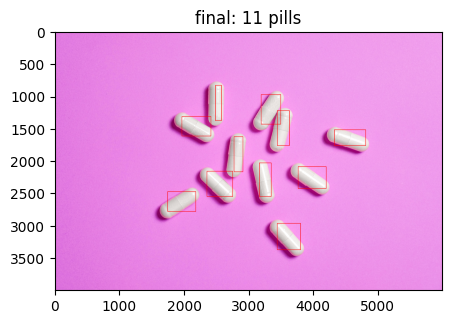

In [20]:
# 2단계: 연결 요소 레이블링 및 카운팅

# 1. 연결 요소 레이블링
num_labels,_, stats, centroids = cv2.connectedComponentsWithStats(erosion, 8, cv2.CV_32S)
# 변수에 각 정보를 저장
#num_labels:총 객체 수
#stats:각 알약의 면적등 수치적 정보
#centroids: 객체의 중심점


# 2. 유효 객체 카운팅 및 필터링
count = img.copy()
#원본이미지를 복사해 count 변수에 저장


MIN_AREA = 200  # 적적 튜닝값.
area = stats[i, cv2.CC_STAT_AREA]



final_count = 0

for i in range(1, num_labels): # 레이블 1부터 시작 (레이블 0은 배경)

    # 면적이 최소 면적 임계값 이상인 경우에만 알약으로 인정
    if area >= MIN_AREA:
        final_count += 1

        # 바운딩 박스 시각화
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        cv2.rectangle(count, (x, y), (x + w, y + h), (0, 0, 255), 5)


print(f"필터링 전 발견된 객체: {num_labels - 1} 개")
print(f"최종 알약 개수 (면적 필터링 후): {final_count} 개")

# 결과 시각화
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(count, cv2.COLOR_BGR2RGB))
plt.title(f'final: {final_count} pills')
plt.show()